In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy import constants as c
from scipy.integrate import quad

In [2]:
P_std = 101325  # Pa
T_15C = 288.15  # K
e_charge = 1.602e-19  # C
mu_air = 1.00000037*c.mu0.value

In [3]:
PMT_min = 185e-9  # m
PMT_max = 650e-9  # m

blue_UV = 380e-9  # m
UVB_UVC = 280e-9  # m

In [4]:
fixed_n = 1.0003
atmos_height = 112.8e3  # m

In [5]:
muon_mass = (105.65837 * u.MeV/c.c**2).to(u.kg).value  # kg
muon_lifetime = 2.19698e-6  # s

In [6]:
# This is to provide some weak dependence of n on lambda.
# This has a modest but appreciable impact in the Frank-Tamm equation due to the factor (1 - 1 / (beta * n))**2)
# Still regard lambda as being photon wavelength in vacuum; lambda = c / nu

def n_air(lam, P=P_std, T=T_15C):
    
    return 1 + 7.76e-7 * (1 + 7.52e-15 / lam**2) * P/T

In [7]:
def d2Ndxdlam(lam, beta, q=e_charge, mu=mu_air):

    return np.pi * q**2 * mu / c.h.value * (c.c.value / lam**2) * (1 - 1 / (beta * n_air(lam))**2)

In [8]:
def dNdx(lam_low, lam_high, beta, q=e_charge, mu=mu_air):

    return quad(d2Ndxdlam, lam_low, lam_high, args=(beta, q, mu))[0]

In [9]:
def get_beta(E, m=c.m_e.value):

    return np.sqrt(1 - m**2 * c.c.value**4 / E**2)

In [10]:
def get_gamma(E, m=c.m_e.value):

    return E / (m * c.c.value**2)

In [11]:
def decay_prob(t, lifetime):

    return 1 - np.exp(-t / lifetime)

In [12]:
def decay_prob_dens(t, lifetime):

    return np.exp(-t / lifetime) / lifetime

In [13]:
def get_cherenkov_angle(beta, n=fixed_n):

    return np.arccos(1 / (beta * n))

In [14]:
# Minimum muon energy (in GeV) to emit Cherenkov radiation in air

min_muon_gamma = (1 - fixed_n**-2) ** -0.5
min_muon_E = min_muon_gamma * muon_mass * c.c.value**2 * u.J.to(u.GeV)
min_muon_E

4.314455366018915

In [15]:
# Make arrays of muon energies

muon_E_span = np.logspace(np.log10(min_muon_E), np.log10(150e3), 10000)  # GeV
muon_energies = np.array([5, 10, 50, 100, 500, 1e3, 10e3, 100e3])  # GeV

In [16]:
# Time and distance arrays

times = np.linspace(0, 7e3 * muon_lifetime, 10000)
dists = np.linspace(0, atmos_height, 10000)

In [17]:
clrs = ['firebrick', 'darkorange', 'gold', 'lime', 'forestgreen', 'dodgerblue', 'blueviolet', 'fuchsia']

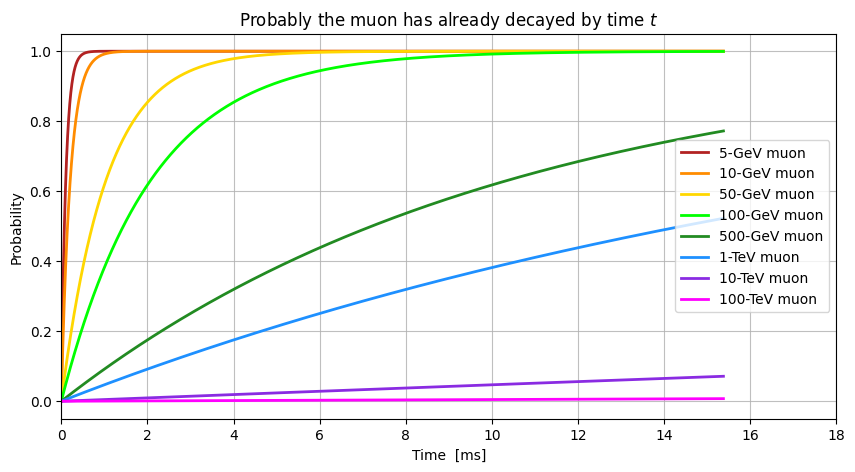

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, E in enumerate(muon_energies):
    gamma = get_gamma(E=E * u.GeV.to(u.J), m=muon_mass)
    if E < 1e3:
        label = str(int(E)) + '-GeV muon'
    else:
        label = str(int(E/1e3)) + '-TeV muon'
    plt.plot(times, decay_prob(times, gamma * muon_lifetime), c=clrs[i], lw=2, label=label)

plt.grid(alpha=0.8)
plt.xlabel('Time  [ms]')
plt.ylabel('Probability')
plt.title(r'Probably the muon has already decayed by time $t$')

ticks = ax.xaxis.axes.get_xticks()
ticks_ms = [str(int(tick * 1e3)) for tick in ticks]
plt.xticks(ticks=ticks, labels=ticks_ms)

plt.xlim(xmin=0)

plt.legend()
plt.show()

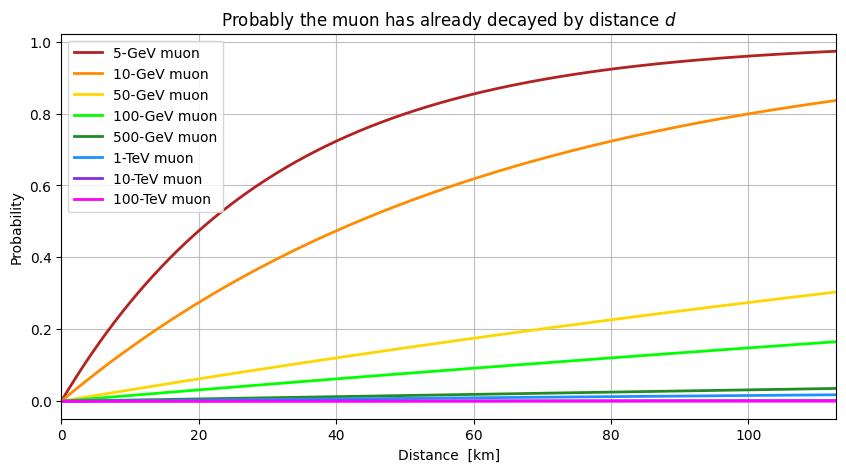

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

# beta = 0.1
# plt.plot(dists, decay_prob(dists / (c.c.value * beta), (1-0.1**2)**-0.5 * muon_lifetime), c='black', ls='--', lw=2, 
#          label='Muon travelling at 10% the speed of light')

for i, E in enumerate(muon_energies):
    
    gamma = get_gamma(E=E * u.GeV.to(u.J), m=muon_mass)
    beta = get_beta(E=E * u.GeV.to(u.J), m=muon_mass)
    
    if E < 1e3:
        label = str(int(E)) + '-GeV muon'
    else:
        label = str(int(E/1e3)) + '-TeV muon'
        
    plt.plot(dists, decay_prob(dists / (c.c.value * beta), gamma * muon_lifetime), c=clrs[i], lw=2, label=label)

plt.grid(alpha=0.8)
plt.xlabel('Distance  [km]')
plt.ylabel('Probability')
plt.title(r'Probably the muon has already decayed by distance $d$')

ticks = ax.xaxis.axes.get_xticks()
ticks_km = [str(int(tick * 1e-3)) for tick in ticks]
plt.xticks(ticks=ticks, labels=ticks_km)

plt.xlim(0, atmos_height)

plt.legend()
plt.show()

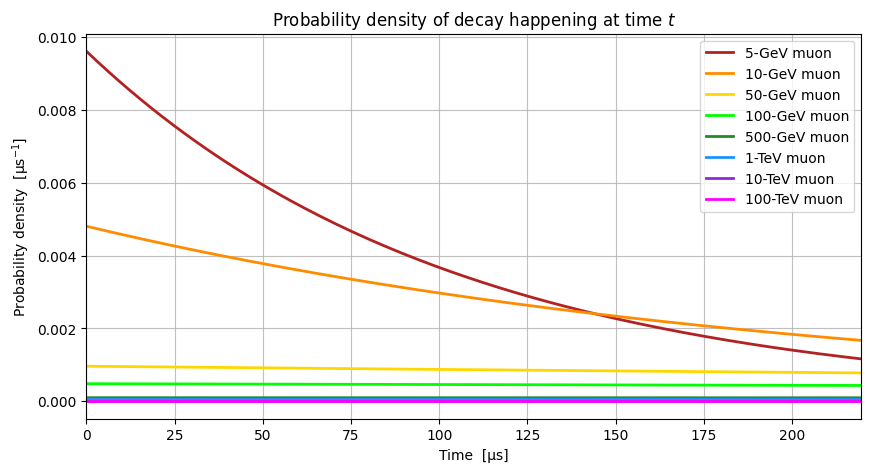

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, E in enumerate(muon_energies):
    gamma = get_gamma(E=E * u.GeV.to(u.J), m=muon_mass)
    if E < 1e3:
        label = str(int(E)) + '-GeV muon'
    else:
        label = str(int(E/1e3)) + '-TeV muon'
    plt.plot(times * 1e6, decay_prob_dens(times * 1e6, gamma * muon_lifetime * 1e6), c=clrs[i], lw=2, label=label)

plt.grid(alpha=0.8)
plt.xlabel('Time  [µs]')
plt.ylabel(r'Probability density  [µs$^{-1}$]')
plt.title(r'Probability density of decay happening at time $t$')

plt.xlim(0, 100 * muon_lifetime * 1e6)

plt.legend()
plt.show()

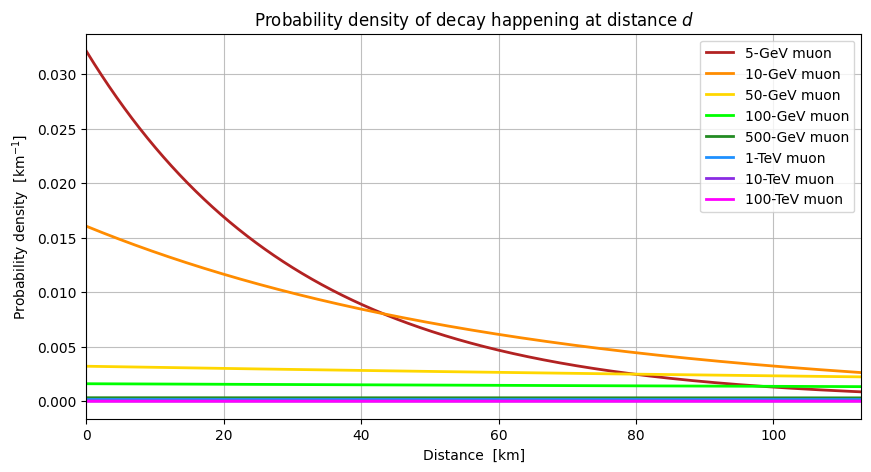

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, E in enumerate(muon_energies):
    gamma = get_gamma(E=E * u.GeV.to(u.J), m=muon_mass)
    if E < 1e3:
        label = str(int(E)) + '-GeV muon'
    else:
        label = str(int(E/1e3)) + '-TeV muon'
    plt.plot(dists * 1e-3, decay_prob_dens(dists * 1e-3, gamma * muon_lifetime * c.c.value * beta * 1e-3), 
             c=clrs[i], lw=2, label=label)

plt.grid(alpha=0.8)
plt.xlabel('Distance  [km]')
plt.ylabel(r'Probability density  [km$^{-1}$]')
plt.title(r'Probability density of decay happening at distance $d$')

plt.xlim(0, atmos_height * 1e-3)

plt.legend()
plt.show()

In [22]:
# Calculate Cherenkov angles = muon ring radius (angular size)

betas = get_beta(E=muon_E_span * u.GeV.to(u.J), m=muon_mass)
angles = get_cherenkov_angle(betas)
angles_deg = angles / np.pi * 180

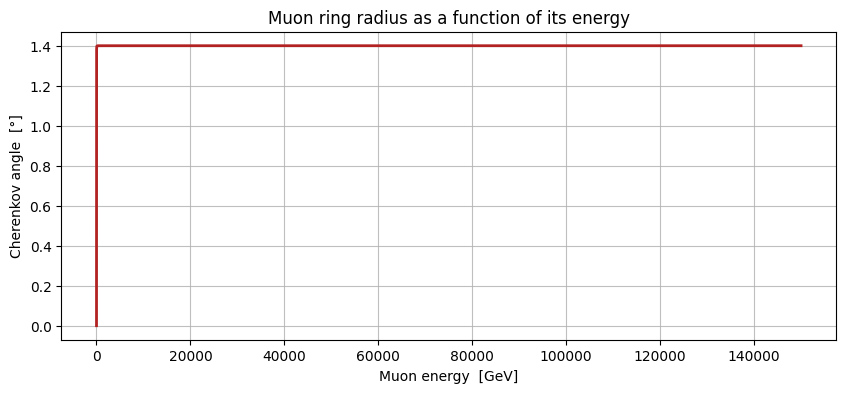

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(muon_E_span, angles_deg, c='firebrick', lw=2)

plt.grid(alpha=0.8)
plt.xlabel('Muon energy  [GeV]')
plt.ylabel('Cherenkov angle  [°]')
plt.title('Muon ring radius as a function of its energy')

plt.show()

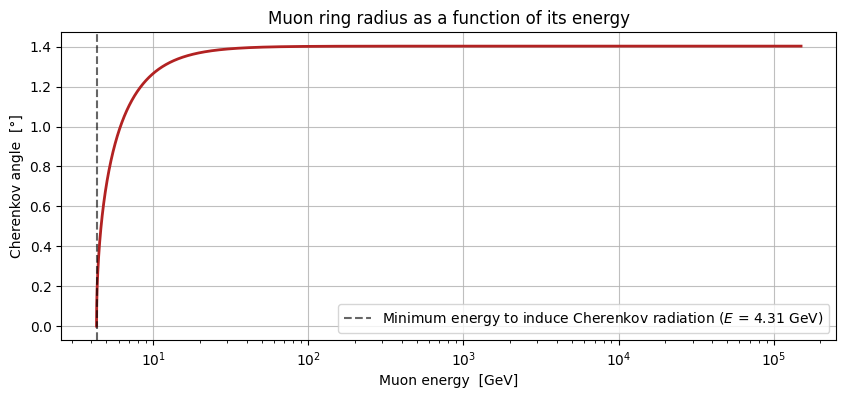

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(muon_E_span, angles_deg, c='firebrick', lw=2)
plt.axvline(x=min_muon_E, color='black', ls='--', lw=1.5, alpha=0.6,
            label=r'Minimum energy to induce Cherenkov radiation ($E$ = {} GeV)'.format(round(min_muon_E, 2)))

plt.grid(alpha=0.8)
plt.xlabel('Muon energy  [GeV]')
plt.ylabel('Cherenkov angle  [°]')
plt.title('Muon ring radius as a function of its energy')

plt.xscale('log')

plt.legend()
plt.show()

In [25]:
# Calculate Cherenkov angles for specific muon energies

some_betas = get_beta(E=muon_energies * u.GeV.to(u.J), m=muon_mass)
some_angles = get_cherenkov_angle(some_betas)
some_angles_deg = some_angles / np.pi * 180

In [26]:
print('Muon ring radii:')
for i, E in enumerate(muon_energies):
    if E < 1e3:
        text = str(int(E)) + '-GeV muon:'
    else:
        text = str(int(E/1e3)) + '-TeV muon:'
    print(text, str(round(some_angles_deg[i], 4)) + '°')

Muon ring radii:
5-GeV muon: 0.7093°
10-GeV muon: 1.266°
50-GeV muon: 1.398°
100-GeV muon: 1.402°
500-GeV muon: 1.4032°
1-TeV muon: 1.4033°
10-TeV muon: 1.4033°
100-TeV muon: 1.4033°


In [27]:
# quad is not well behaved for muons with too low energies.
# Because of n dependence on emitted photon wavelength, 
# muons near energy threshold aren't inducing Cherenkov radiation 
# at all wavelengths between UVB_UVC and PMT_max (limits of integration).

condition = muon_E_span >= 4.5

ring_intensities = np.zeros_like(betas[condition])

for i, beta in enumerate(betas[condition]):
    ring_intensities[i] = dNdx(lam_low=UVB_UVC, lam_high=PMT_max, beta=beta)

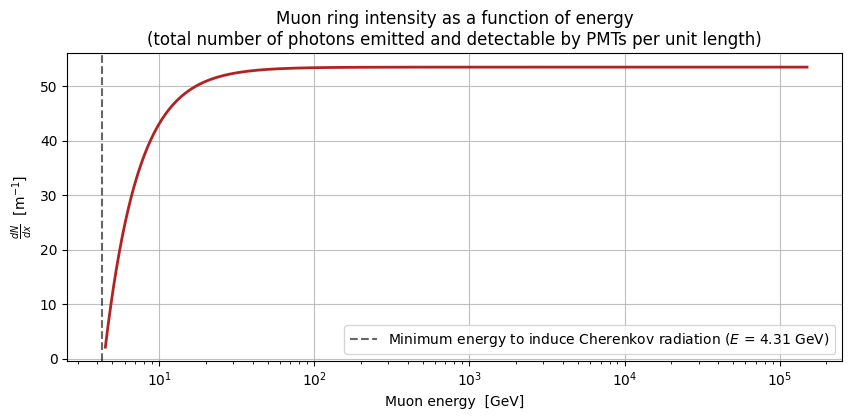

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(muon_E_span[condition], ring_intensities, c='firebrick', lw=2)
plt.axvline(x=min_muon_E, color='black', ls='--', lw=1.5, alpha=0.6,
            label=r'Minimum energy to induce Cherenkov radiation ($E$ = {} GeV)'.format(round(min_muon_E, 2)))

plt.grid(alpha=0.8)
plt.xlabel('Muon energy  [GeV]')
plt.ylabel(r'$\frac{dN}{dx}$  [m$^{-1}$]')
plt.title('Muon ring intensity as a function of energy' 
          + '\n(total number of photons emitted and detectable by PMTs per unit length)')

plt.xscale('log')

plt.legend()
plt.show()

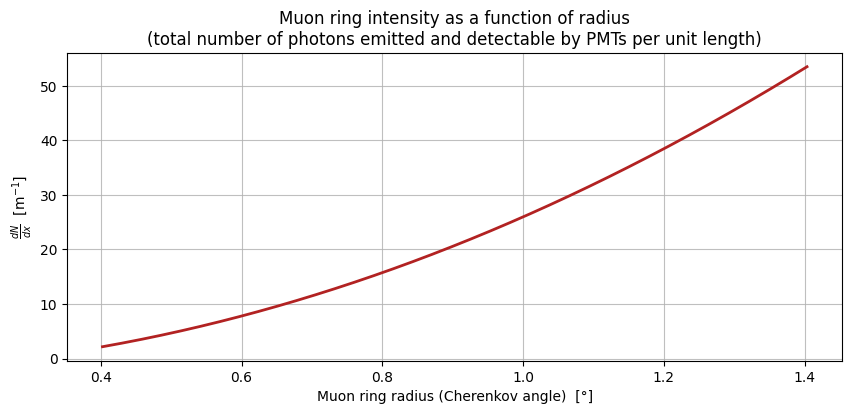

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(angles_deg[condition], ring_intensities, c='firebrick', lw=2)

plt.grid(alpha=0.8)
plt.xlabel('Muon ring radius (Cherenkov angle)  [°]')
plt.ylabel(r'$\frac{dN}{dx}$  [m$^{-1}$]')
plt.title('Muon ring intensity as a function of radius' 
          + '\n(total number of photons emitted and detectable by PMTs per unit length)')

# plt.xlim(xmin=0)

plt.show()

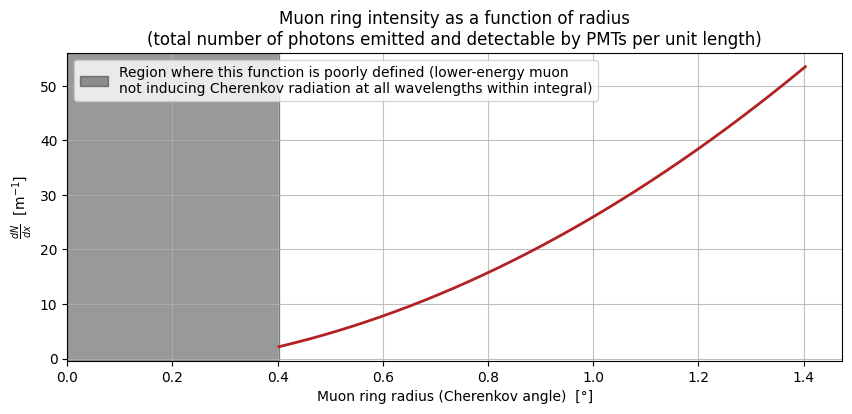

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(angles_deg[condition], ring_intensities, c='firebrick', lw=2)

plt.axvspan(0, np.min(angles_deg[condition]), color='black', alpha=0.4, 
            label='Region where this function is poorly defined (lower-energy muon' 
            + '\nnot inducing Cherenkov radiation at all wavelengths within integral)')

plt.grid(alpha=0.8)
plt.xlabel('Muon ring radius (Cherenkov angle)  [°]')
plt.ylabel(r'$\frac{dN}{dx}$  [m$^{-1}$]')
plt.title('Muon ring intensity as a function of radius' 
          + '\n(total number of photons emitted and detectable by PMTs per unit length)')

plt.xlim(xmin=0)

plt.legend()
plt.show()